<a href="https://colab.research.google.com/github/ShotaArima/zemi-camp/blob/main/Bank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [4]:
bank = pd.read_csv("/content/drive/MyDrive/ゼミ合宿/bank.csv", sep=";")
bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


# 説明変数の説明




- month
  最後に連絡を取った月。季節や月ごとのトレンドが顧客の行動に影響することが考えられます。

- duration
  連絡の持続時間（秒単位）。連絡が長く続いた場合、顧客がキャンペーンに興味を持っている可能性があります。

- ampaign
  このキャンペーンで顧客に連絡した回数。何度も連絡を取った場合、顧客の反応が変わる可能性があります。

- pdays
  前回のキャンペーンで顧客と最後に接触してからの日数。-1は前回接触がなかったことを示します。以前のキャンペーンが成功しているかどうかを判断する要因です。

- previous
  前回のキャンペーンで顧客と接触した回数。過去のキャンペーンの影響を評価するための変数です。

- poutcome
  前回のキャンペーンの結果（例：unknown, failure, success）。過去のキャンペーンが成功したかどうかが、今回のキャンペーンの結果に影響を与える可能性があります。

# データの確認

In [5]:
# 全行数と列数を確認
print(f"全データ数: {bank.shape[0]}行 × {bank.shape[1]}列")

# 各列の値の分布を確認
for column in bank.columns:
    print(f"\n{column} 列の値の分布:")
    print(bank[column].value_counts())

全データ数: 4521行 × 17列

age 列の値の分布:
age
34    231
32    224
31    199
36    188
33    186
     ... 
68      2
87      1
81      1
86      1
84      1
Name: count, Length: 67, dtype: int64

job 列の値の分布:
job
management       969
blue-collar      946
technician       768
admin.           478
services         417
retired          230
self-employed    183
entrepreneur     168
unemployed       128
housemaid        112
student           84
unknown           38
Name: count, dtype: int64

marital 列の値の分布:
marital
married     2797
single      1196
divorced     528
Name: count, dtype: int64

education 列の値の分布:
education
secondary    2306
tertiary     1350
primary       678
unknown       187
Name: count, dtype: int64

default 列の値の分布:
default
no     4445
yes      76
Name: count, dtype: int64

balance 列の値の分布:
balance
0       357
2        24
1        15
4        13
5        11
       ... 
539       1
1041      1
464       1
7702      1
1137      1
Name: count, Length: 2353, dtype: int64

housing 列の値の分布:
hou

In [6]:
# 各カラムの欠損値の数を確認
missing_values = bank.isnull().sum()

# 欠損値の有無を出力
print("各カラムの欠損値の数:")
print(missing_values)

# 欠損値が存在するカラムのみ表示
print("\n欠損値が存在するカラム:")
print(missing_values[missing_values > 0])

各カラムの欠損値の数:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

欠損値が存在するカラム:
Series([], dtype: int64)


## 10分割交差検定

In [54]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import numpy as np

# 説明変数と目的変数に分割
X = bank.drop(columns=['y'])  # 説明変数
y = bank['y']  # 目的変数

# 10分割交差検定の設定（層化交差検定でラベルの割合を保つ）
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 全てのfoldのインデックスを取得
fold_indices = list(kf.split(X, y))

# 5個のfoldからランダムに1つ選ぶ
np.random.seed(42)  # 再現性のためのシード
test_fold_index = np.random.choice(len(fold_indices), size=1, replace=False)[0]

# 選ばれたfoldをテストデータにし、残りを学習データにする
test_indices = fold_indices[test_fold_index][1]
train_indices = np.concatenate([fold_indices[i][0] for i in range(len(fold_indices)) if i != test_fold_index])

# 学習データとテストデータを分割
train_x, train_y = X.iloc[train_indices], y.iloc[train_indices]
test_x, test_y = X.iloc[test_indices], y.iloc[test_indices]
# test_x,  = X.iloc[test_indices]

# 出力（必要に応じて表示を省略可能）
print(f"選ばれたテストfoldの番号: {test_fold_indices}")
print(f"train_x shape: {train_x.shape}, train_y shape: {train_y.shape}")
print(f"test_x shape: {test_x.shape}")

# ここでtrain_x, train_y, test_xを使ってモデルを学習・評価します
# 必要に応じて、train_x, train_y, test_xを保存・処理するコードを追加してください


選ばれたテストfoldの番号: [1]
train_x shape: (14467, 16), train_y shape: (14467,)
test_x shape: (904, 16)


# 学習データとテストデータのフレーム

In [10]:
train_x.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown


In [11]:
train_y.head()

,y
0,no
1,no
2,no
3,no
4,no


In [12]:
test_x.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure
10,39,services,married,secondary,no,9374,yes,no,unknown,20,may,273,1,-1,0,unknown
16,56,technician,married,secondary,no,4073,no,no,cellular,27,aug,239,5,-1,0,unknown
23,44,entrepreneur,married,secondary,no,93,no,no,cellular,7,jul,125,2,-1,0,unknown
28,56,self-employed,married,secondary,no,784,no,yes,cellular,30,jul,149,2,-1,0,unknown


In [13]:
test_y.head()

,y
1,no
10,no
16,no
23,no
28,no


## 相関関係

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

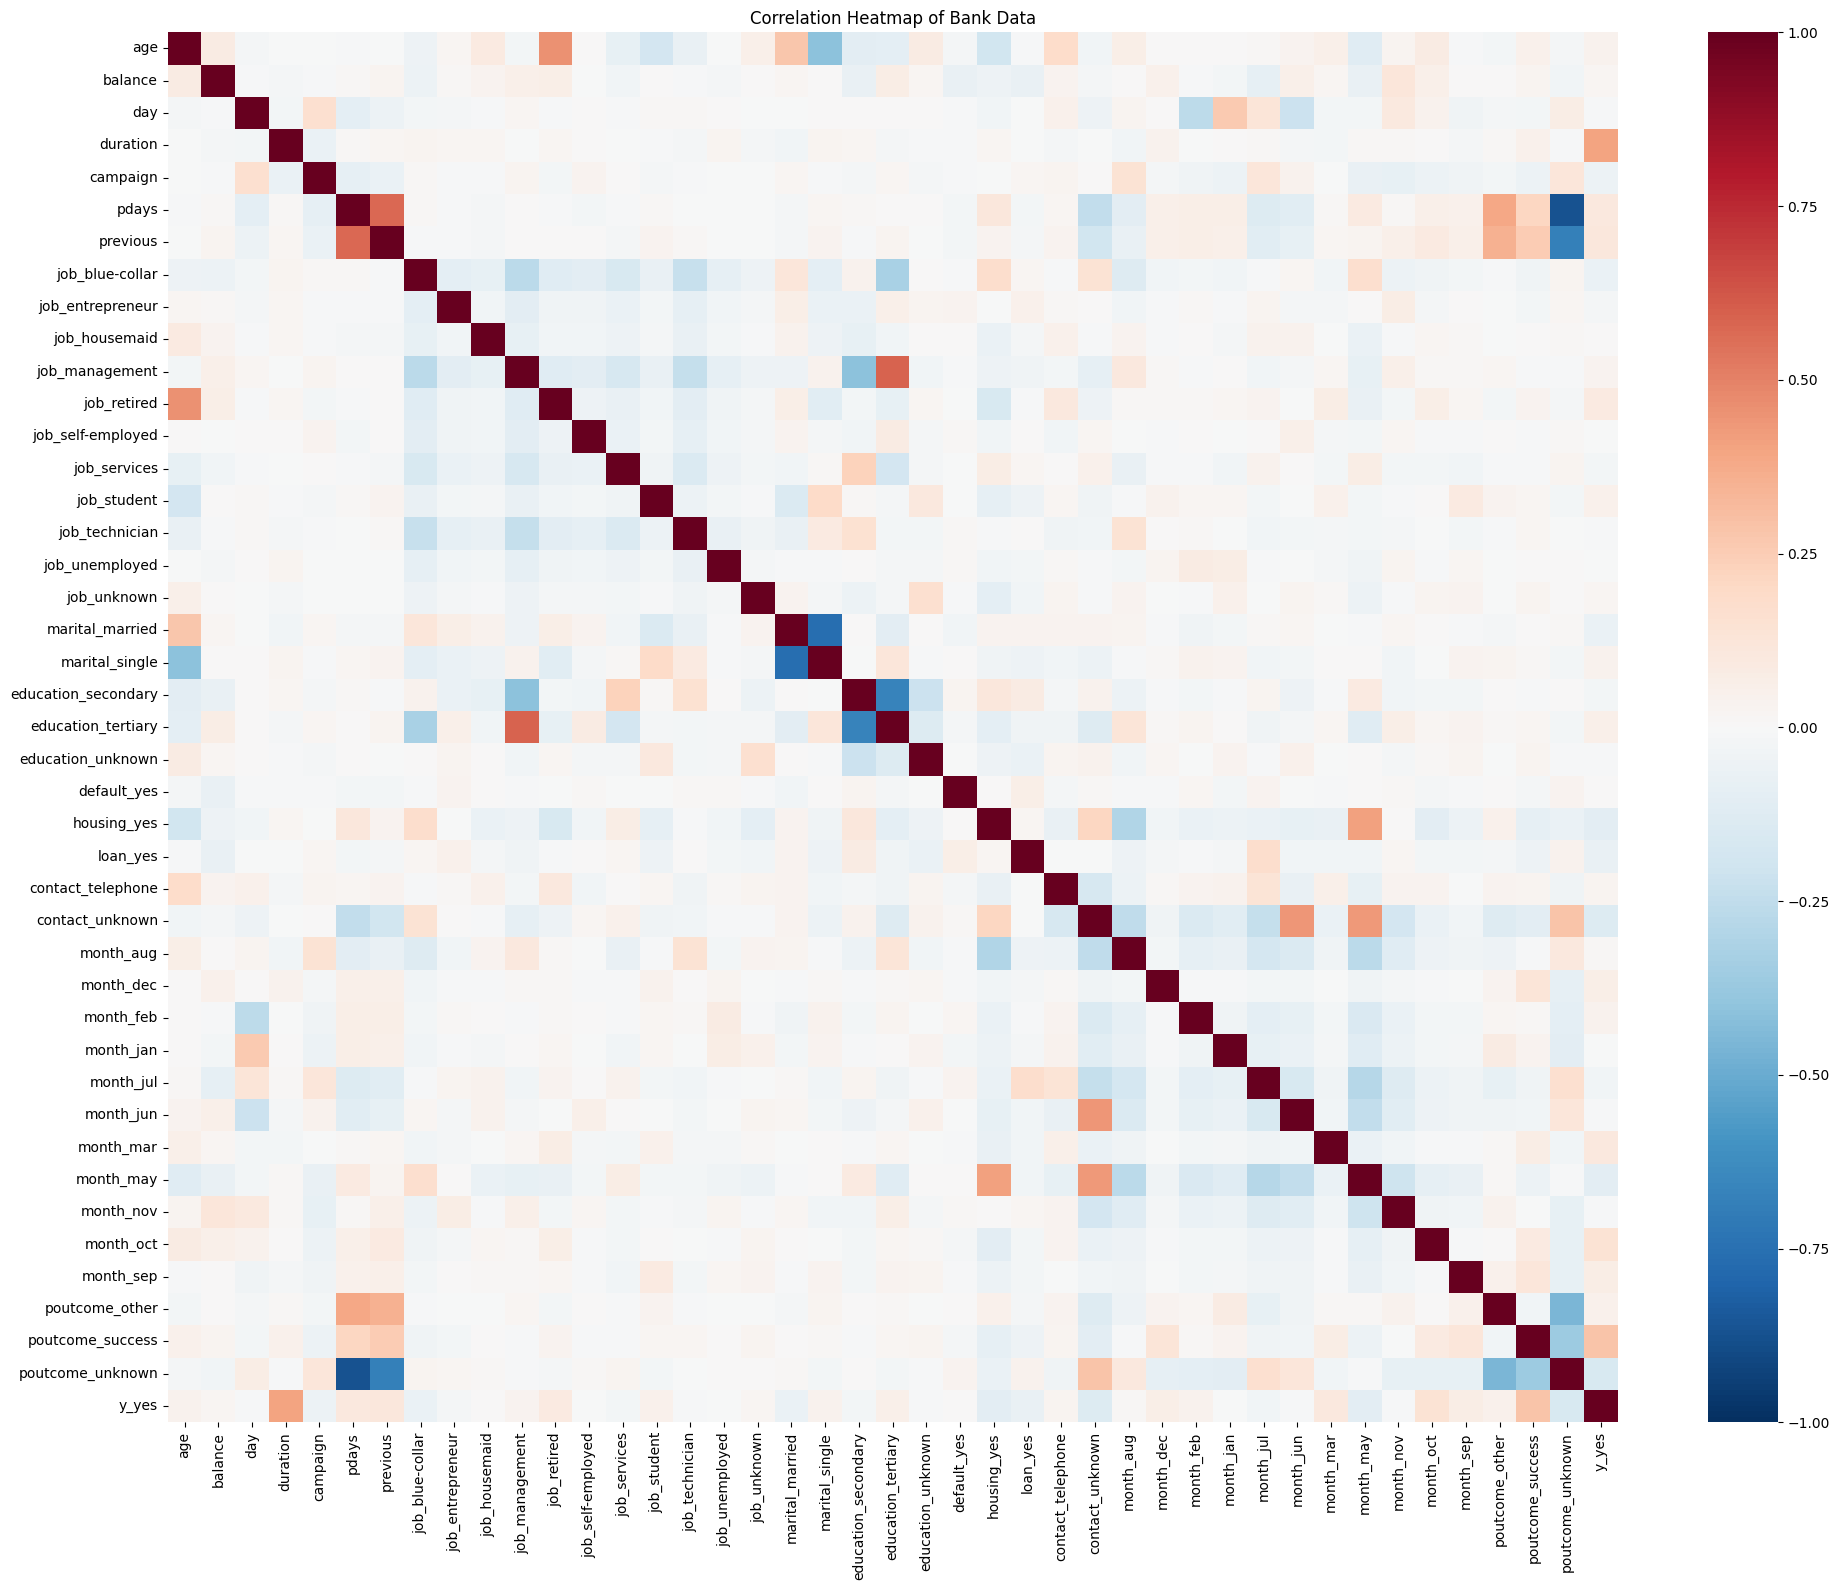

In [15]:
# カテゴリカル変数の特定
categorical_columns = bank.select_dtypes(include=['object']).columns

# カテゴリカル変数をダミー変数化
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=True)

# 相関係数の計算
correlation_matrix = bank_encoded.corr()

# ヒートマップの作成
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Bank Data')
plt.tight_layout()
plt.show()

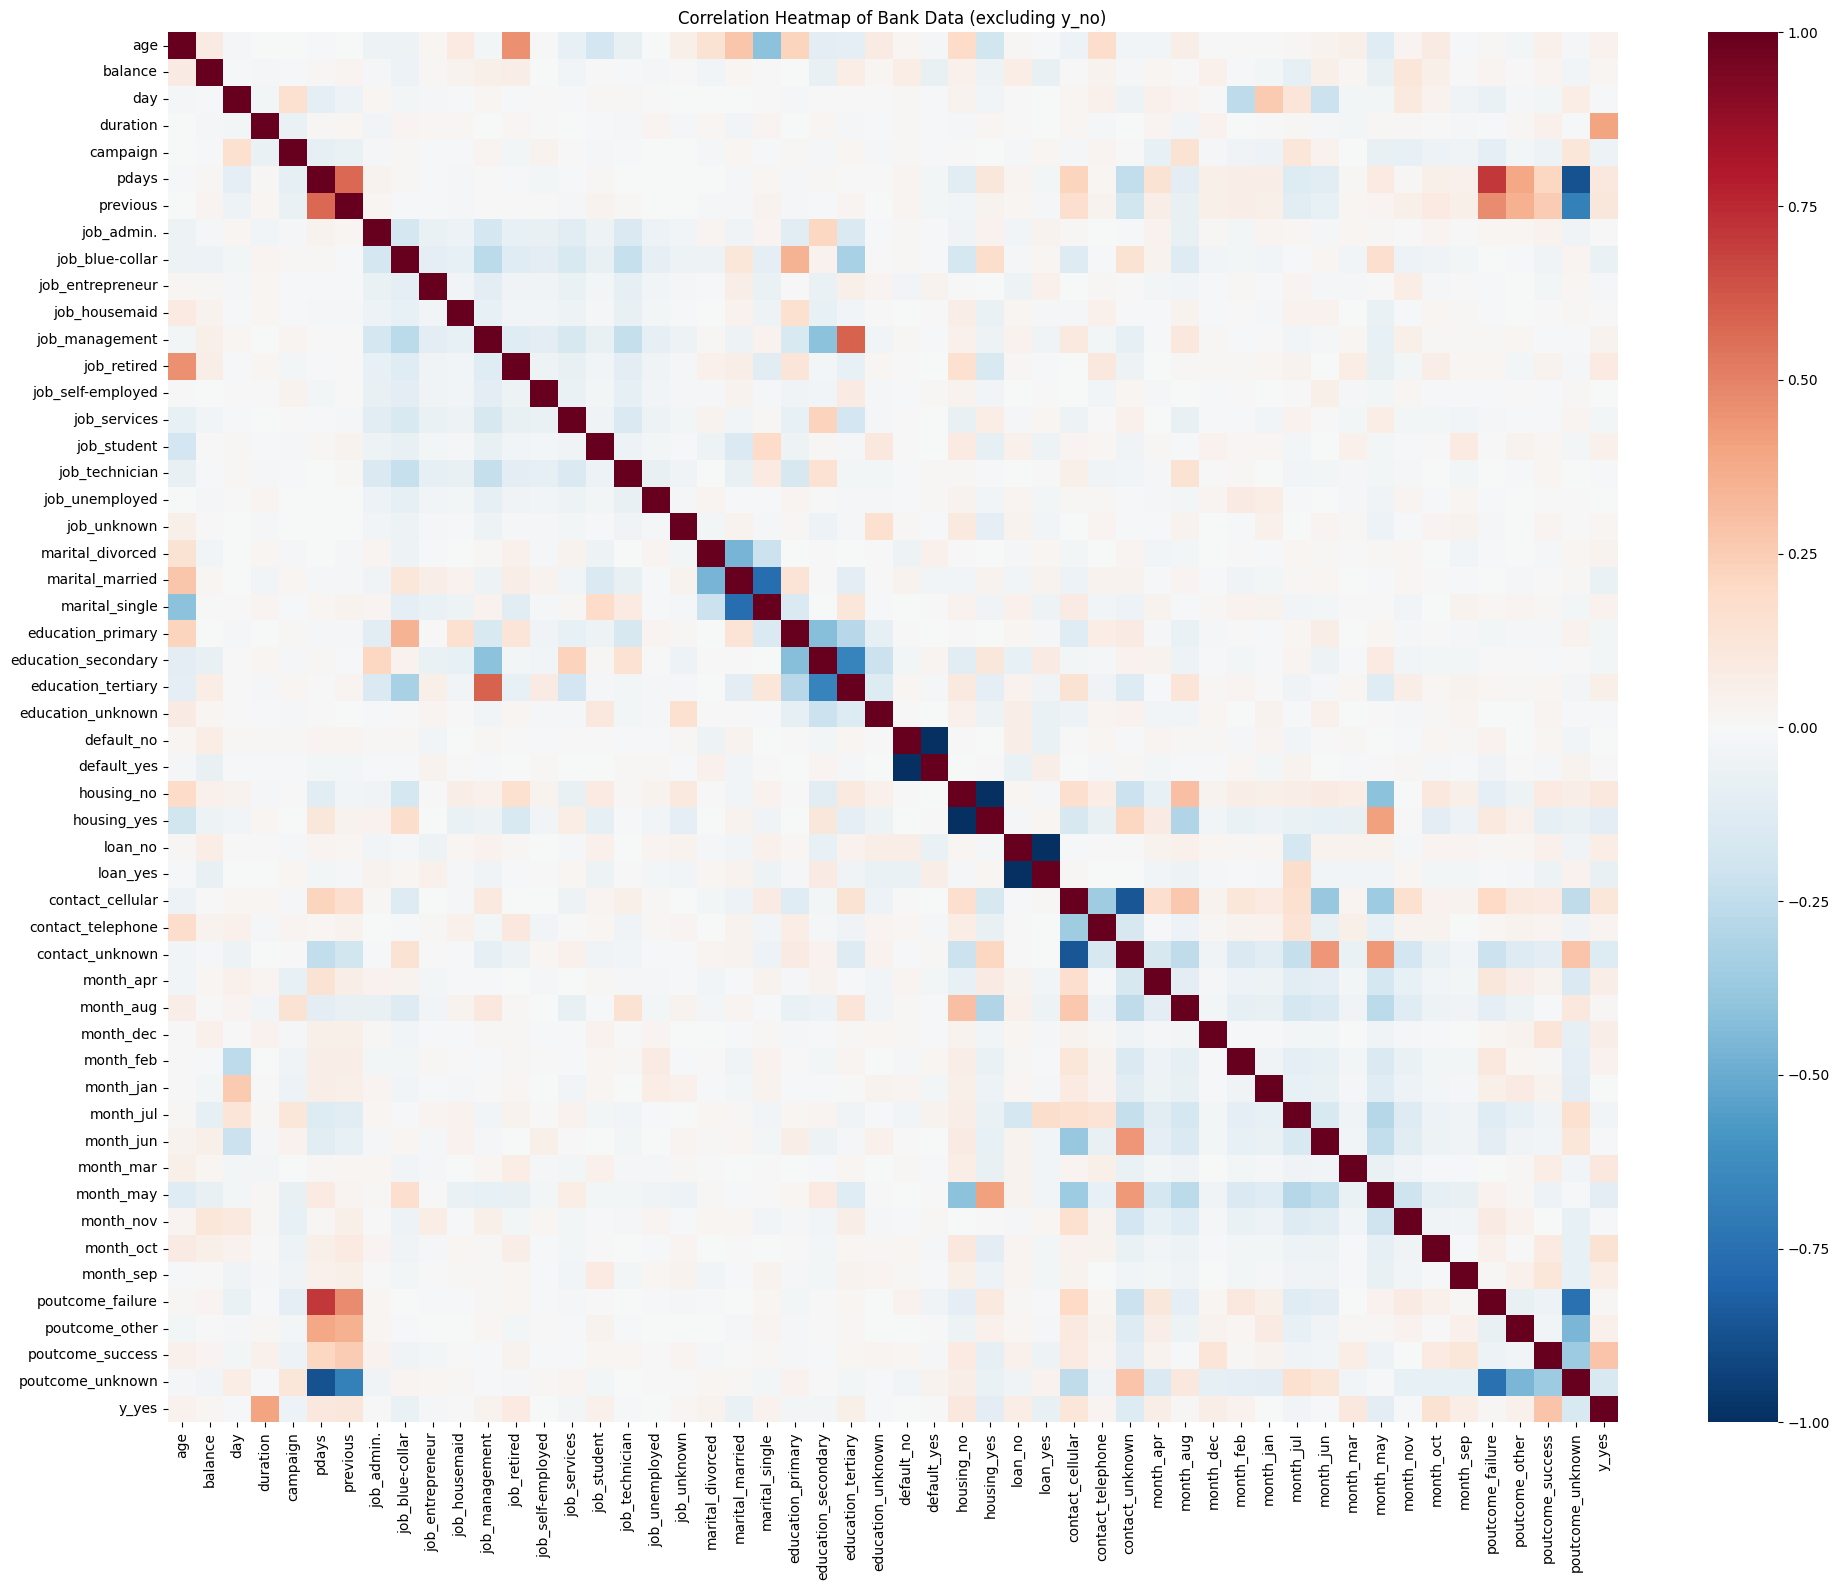

Correlations with y_yes (excluding y_no):
duration               0.401118
poutcome_success       0.283481
month_oct              0.145964
contact_cellular       0.118761
previous               0.116714
housing_no             0.104683
pdays                  0.104087
month_mar              0.102716
job_retired            0.086675
month_sep              0.071510
loan_no                0.070517
month_dec              0.069884
month_apr              0.062563
education_tertiary     0.056649
poutcome_other         0.051908
job_student            0.047809
marital_single         0.045815
age                    0.045092
month_feb              0.039805
marital_divorced       0.034840
job_management         0.032634
contact_telephone      0.025878
job_unknown            0.019886
balance                0.017905
poutcome_failure       0.014556
month_aug              0.012084
job_admin.             0.006568
job_housemaid          0.004872
default_yes            0.001303
default_no            -0.00130

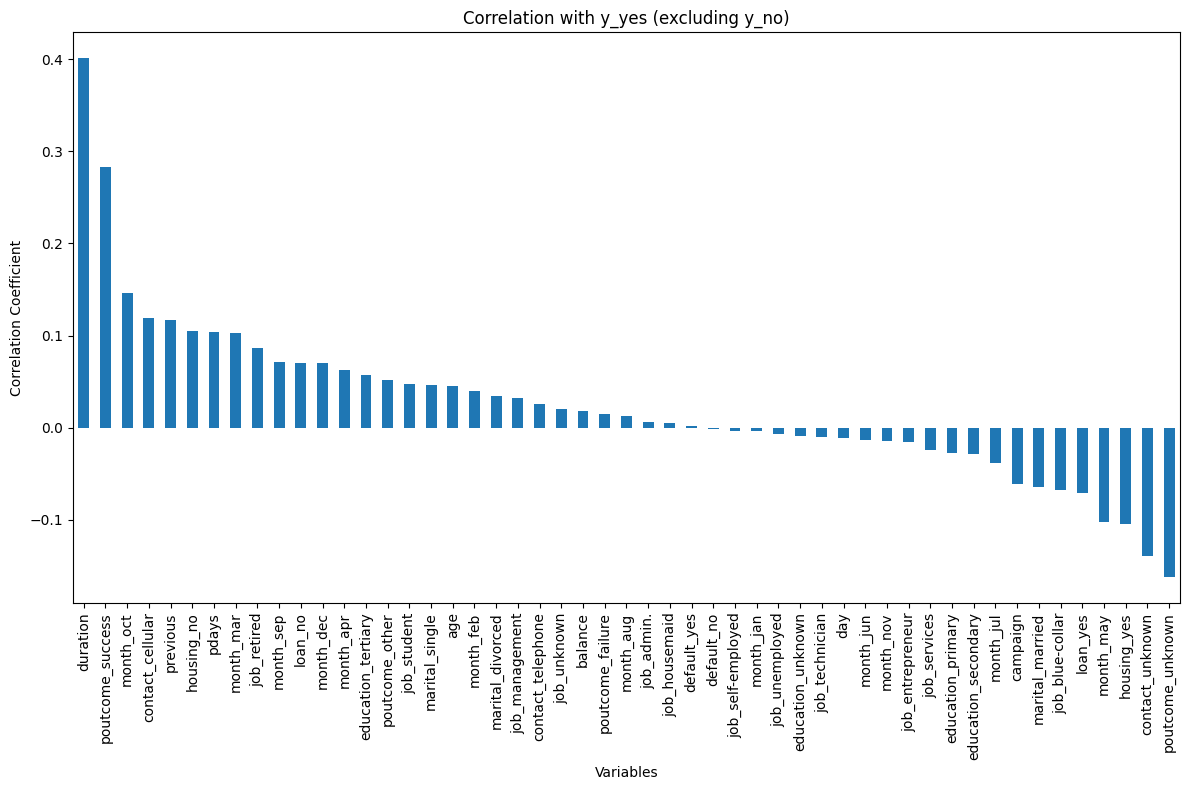

In [16]:
# カテゴリカル変数の特定
categorical_columns = bank.select_dtypes(include=['object']).columns

# カテゴリカル変数をダミー変数化
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# y_noカラムが存在する場合、それを削除
if 'y_no' in bank_encoded.columns:
    bank_encoded = bank_encoded.drop('y_no', axis=1)

# 相関係数の計算
correlation_matrix = bank_encoded.corr()

# ヒートマップの作成
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Bank Data (excluding y_no)')
plt.tight_layout()
plt.show()

# y_yesに対する各変数の相関係数を計算
y_yes_correlations = correlation_matrix['y_yes'].sort_values(ascending=False)

# y_yesを除外（自身との相関は常に1なので）
y_yes_correlations = y_yes_correlations.drop('y_yes')

# 結果の出力
print("Correlations with y_yes (excluding y_no):")
print(y_yes_correlations)

# 相関係数の棒グラフ作成
plt.figure(figsize=(12, 8))
y_yes_correlations.plot(kind='bar')
plt.title('Correlation with y_yes (excluding y_no)')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Strong correlations with y_yes (|correlation| >= 0.1):
duration            0.401118
poutcome_success    0.283481
month_oct           0.145964
contact_cellular    0.118761
previous            0.116714
housing_no          0.104683
pdays               0.104087
month_mar           0.102716
month_may          -0.102077
housing_yes        -0.104683
contact_unknown    -0.139399
poutcome_unknown   -0.162038
Name: y_yes, dtype: float64


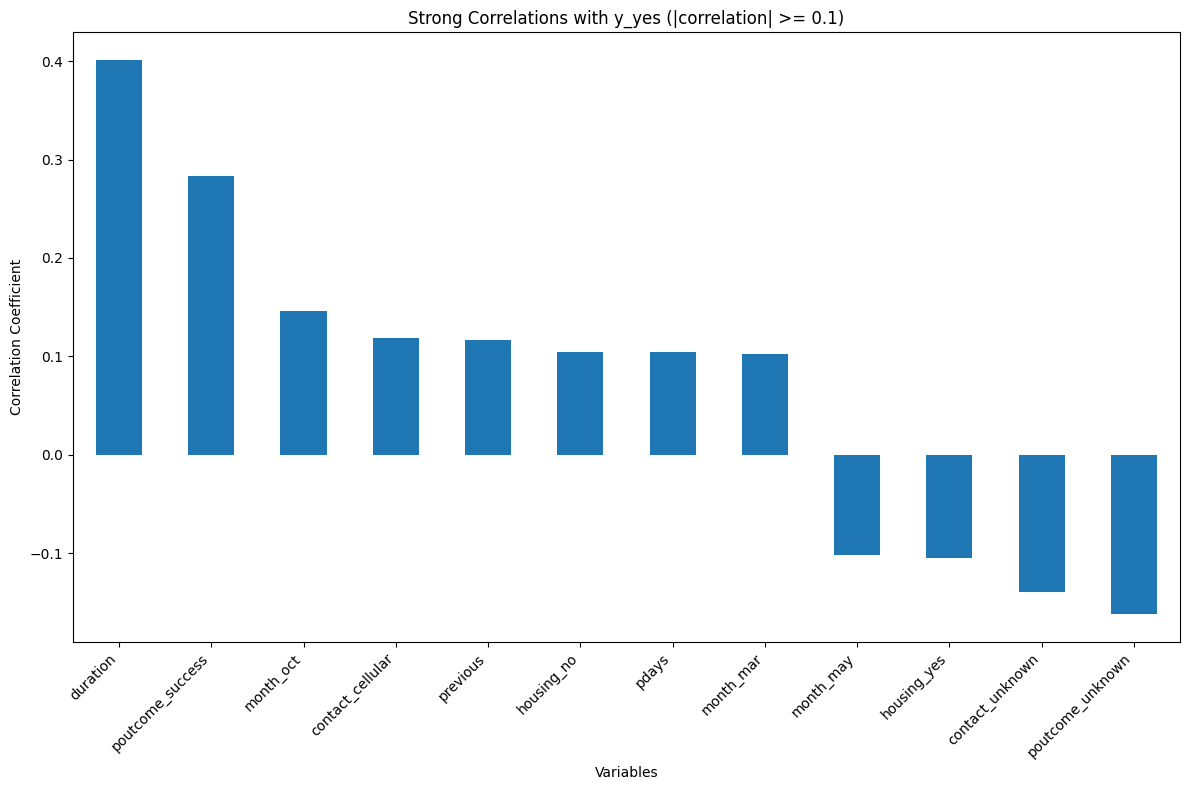

In [17]:
strong_correlations = y_yes_correlations[abs(y_yes_correlations) >= 0.1].sort_values(ascending=False)

print("Strong correlations with y_yes (|correlation| >= 0.1):")
print(strong_correlations)

# 強い相関のある変数の棒グラフ作成
plt.figure(figsize=(12, 8))
strong_correlations.plot(kind='bar')
plt.title('Strong Correlations with y_yes (|correlation| >= 0.1)')
plt.xlabel('Variables')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 分析

## knn

In [36]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# 指定された変数を選択
selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
X = bank_encoded[selected_features]

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in range(1,100):
  # KNNモデルの初期化（k=5と仮定）
  model = KNeighborsClassifier(n_neighbors=k)

  # 交差検証の実行
  accuracies = []

  for train_index, test_index in skf.split(X_scaled, y):
      X_train, X_test = X_scaled[train_index], X_scaled[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # # 訓練データとテストデータの比率を8:2に調整
      # train_size = int(0.8 * len(X_train))
      # X_train = X_train[:train_size]
      # y_train = y_train[:train_size]

      # モデルの学習と予測
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # 精度の計算
      accuracy = accuracy_score(y_test, y_pred)
      accuracies.append(accuracy)

  # 平均精度の計算と表示
  mean_accuracy = np.mean(accuracies)
  print(f"k={k}の5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

k=1の5分割交差検証の平均精度（Accuracy）: 0.8604
k=2の5分割交差検証の平均精度（Accuracy）: 0.8872
k=3の5分割交差検証の平均精度（Accuracy）: 0.8821
k=4の5分割交差検証の平均精度（Accuracy）: 0.8896
k=5の5分割交差検証の平均精度（Accuracy）: 0.8843
k=6の5分割交差検証の平均精度（Accuracy）: 0.8901
k=7の5分割交差検証の平均精度（Accuracy）: 0.8885
k=8の5分割交差検証の平均精度（Accuracy）: 0.8927
k=9の5分割交差検証の平均精度（Accuracy）: 0.8932
k=10の5分割交差検証の平均精度（Accuracy）: 0.8940
k=11の5分割交差検証の平均精度（Accuracy）: 0.8967
k=12の5分割交差検証の平均精度（Accuracy）: 0.8938
k=13の5分割交差検証の平均精度（Accuracy）: 0.8960
k=14の5分割交差検証の平均精度（Accuracy）: 0.8956
k=15の5分割交差検証の平均精度（Accuracy）: 0.8978
k=16の5分割交差検証の平均精度（Accuracy）: 0.8989
k=17の5分割交差検証の平均精度（Accuracy）: 0.8983
k=18の5分割交差検証の平均精度（Accuracy）: 0.8980
k=19の5分割交差検証の平均精度（Accuracy）: 0.8969
k=20の5分割交差検証の平均精度（Accuracy）: 0.8989
k=21の5分割交差検証の平均精度（Accuracy）: 0.8983
k=22の5分割交差検証の平均精度（Accuracy）: 0.8969
k=23の5分割交差検証の平均精度（Accuracy）: 0.8969
k=24の5分割交差検証の平均精度（Accuracy）: 0.8976
k=25の5分割交差検証の平均精度（Accuracy）: 0.8976
k=26の5分割交差検証の平均精度（Accuracy）: 0.8980
k=27の5分割交差検証の平均精度（Accuracy）: 0.8996
k=28の5分割交差検証の平均精度（Accuracy）: 0.9005
k

In [37]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
# selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
# X = bank_encoded[selected_features]

# 全ての変数を使用
X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for k in range(1,100):
  # KNNモデルの初期化（k=5と仮定）
  model = KNeighborsClassifier(n_neighbors=k)

  # 交差検証の実行
  accuracies = []

  for train_index, test_index in skf.split(X_scaled, y):
      X_train, X_test = X_scaled[train_index], X_scaled[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # # 訓練データとテストデータの比率を8:2に調整
      # train_size = int(0.8 * len(X_train))
      # X_train = X_train[:train_size]
      # y_train = y_train[:train_size]

      # モデルの学習と予測
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # 精度の計算
      accuracy = accuracy_score(y_test, y_pred)
      accuracies.append(accuracy)

  # 平均精度の計算と表示
  mean_accuracy = np.mean(accuracies)
  print(f"k={k}の5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

k=1の5分割交差検証の平均精度（Accuracy）: 0.8649
k=2の5分割交差検証の平均精度（Accuracy）: 0.8841
k=3の5分割交差検証の平均精度（Accuracy）: 0.8808
k=4の5分割交差検証の平均精度（Accuracy）: 0.8874
k=5の5分割交差検証の平均精度（Accuracy）: 0.8881
k=6の5分割交差検証の平均精度（Accuracy）: 0.8868
k=7の5分割交差検証の平均精度（Accuracy）: 0.8870
k=8の5分割交差検証の平均精度（Accuracy）: 0.8874
k=9の5分割交差検証の平均精度（Accuracy）: 0.8859
k=10の5分割交差検証の平均精度（Accuracy）: 0.8867
k=11の5分割交差検証の平均精度（Accuracy）: 0.8870
k=12の5分割交差検証の平均精度（Accuracy）: 0.8861
k=13の5分割交差検証の平均精度（Accuracy）: 0.8883
k=14の5分割交差検証の平均精度（Accuracy）: 0.8872
k=15の5分割交差検証の平均精度（Accuracy）: 0.8865
k=16の5分割交差検証の平均精度（Accuracy）: 0.8865
k=17の5分割交差検証の平均精度（Accuracy）: 0.8861
k=18の5分割交差検証の平均精度（Accuracy）: 0.8874
k=19の5分割交差検証の平均精度（Accuracy）: 0.8863
k=20の5分割交差検証の平均精度（Accuracy）: 0.8861
k=21の5分割交差検証の平均精度（Accuracy）: 0.8868
k=22の5分割交差検証の平均精度（Accuracy）: 0.8859
k=23の5分割交差検証の平均精度（Accuracy）: 0.8872
k=24の5分割交差検証の平均精度（Accuracy）: 0.8867
k=25の5分割交差検証の平均精度（Accuracy）: 0.8883
k=26の5分割交差検証の平均精度（Accuracy）: 0.8876
k=27の5分割交差検証の平均精度（Accuracy）: 0.8887
k=28の5分割交差検証の平均精度（Accuracy）: 0.8876
k

## XGBppst
- 相関係数の絶対値が0.1以上の変数のみ
- 全ての変数

In [22]:
from xgboost import XGBClassifier

In [47]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
X = bank_encoded[selected_features]

# 全ての変数を使用
# X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in range(20, 500, 10):
  # XGBoostモデルの初期化（n_estimators=20, random_state=71と仮定）
  model = XGBClassifier(n_estimators=n, random_state=71)

  # 交差検証の実行
  accuracies = []

  for train_index, test_index in skf.split(X_scaled, y):
      X_train, X_test = X_scaled[train_index], X_scaled[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # # 訓練データとテストデータの比率を8:2に調整
      # train_size = int(0.8 * len(X_train))
      # X_train = X_train[:train_size]
      # y_train = y_train[:train_size]

      # モデルの学習と予測
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # 精度の計算
      accuracy = accuracy_score(y_test, y_pred)
      accuracies.append(accuracy)

  # 平均精度の計算と表示
  mean_accuracy = np.mean(accuracies)
  print(f"n_estimators={n}の5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

n_estimators=20の5分割交差検証の平均精度（Accuracy）: 0.8989
n_estimators=30の5分割交差検証の平均精度（Accuracy）: 0.8963
n_estimators=40の5分割交差検証の平均精度（Accuracy）: 0.8967
n_estimators=50の5分割交差検証の平均精度（Accuracy）: 0.8949
n_estimators=60の5分割交差検証の平均精度（Accuracy）: 0.8958
n_estimators=70の5分割交差検証の平均精度（Accuracy）: 0.8954
n_estimators=80の5分割交差検証の平均精度（Accuracy）: 0.8956
n_estimators=90の5分割交差検証の平均精度（Accuracy）: 0.8958
n_estimators=100の5分割交差検証の平均精度（Accuracy）: 0.8943
n_estimators=110の5分割交差検証の平均精度（Accuracy）: 0.8938
n_estimators=120の5分割交差検証の平均精度（Accuracy）: 0.8936
n_estimators=130の5分割交差検証の平均精度（Accuracy）: 0.8936
n_estimators=140の5分割交差検証の平均精度（Accuracy）: 0.8929
n_estimators=150の5分割交差検証の平均精度（Accuracy）: 0.8936
n_estimators=160の5分割交差検証の平均精度（Accuracy）: 0.8929
n_estimators=170の5分割交差検証の平均精度（Accuracy）: 0.8943
n_estimators=180の5分割交差検証の平均精度（Accuracy）: 0.8936
n_estimators=190の5分割交差検証の平均精度（Accuracy）: 0.8936
n_estimators=200の5分割交差検証の平均精度（Accuracy）: 0.8934
n_estimators=210の5分割交差検証の平均精度（Accuracy）: 0.8934
n_estimators=220の5分割交差検証の平均精度（Accuracy）: 0.8941


In [49]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
# selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
# X = bank_encoded[selected_features]

# 全ての変数を使用
X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in range(20, 500, 10):
  # モデル初期化
  model = XGBClassifier(n_estimators=n, random_state=71)

  # 交差検証の実行
  accuracies = []

  for train_index, test_index in skf.split(X_scaled, y):
      X_train, X_test = X_scaled[train_index], X_scaled[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # # 訓練データとテストデータの比率を8:2に調整
      # train_size = int(0.8 * len(X_train))
      # X_train = X_train[:train_size]
      # y_train = y_train[:train_size]

      # モデルの学習と予測
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # 精度の計算
      accuracy = accuracy_score(y_test, y_pred)
      accuracies.append(accuracy)

  # 平均精度の計算と表示
  mean_accuracy = np.mean(accuracies)
  print(f"n={n}の5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

n=20の5分割交差検証の平均精度（Accuracy）: 0.8958
n=30の5分割交差検証の平均精度（Accuracy）: 0.8958
n=40の5分割交差検証の平均精度（Accuracy）: 0.8969
n=50の5分割交差検証の平均精度（Accuracy）: 0.8967
n=60の5分割交差検証の平均精度（Accuracy）: 0.8960
n=70の5分割交差検証の平均精度（Accuracy）: 0.8938
n=80の5分割交差検証の平均精度（Accuracy）: 0.8934
n=90の5分割交差検証の平均精度（Accuracy）: 0.8938
n=100の5分割交差検証の平均精度（Accuracy）: 0.8943
n=110の5分割交差検証の平均精度（Accuracy）: 0.8941
n=120の5分割交差検証の平均精度（Accuracy）: 0.8932
n=130の5分割交差検証の平均精度（Accuracy）: 0.8938
n=140の5分割交差検証の平均精度（Accuracy）: 0.8927
n=150の5分割交差検証の平均精度（Accuracy）: 0.8941
n=160の5分割交差検証の平均精度（Accuracy）: 0.8941
n=170の5分割交差検証の平均精度（Accuracy）: 0.8943
n=180の5分割交差検証の平均精度（Accuracy）: 0.8938
n=190の5分割交差検証の平均精度（Accuracy）: 0.8932
n=200の5分割交差検証の平均精度（Accuracy）: 0.8943
n=210の5分割交差検証の平均精度（Accuracy）: 0.8932
n=220の5分割交差検証の平均精度（Accuracy）: 0.8932
n=230の5分割交差検証の平均精度（Accuracy）: 0.8925
n=240の5分割交差検証の平均精度（Accuracy）: 0.8929
n=250の5分割交差検証の平均精度（Accuracy）: 0.8934
n=260の5分割交差検証の平均精度（Accuracy）: 0.8936
n=270の5分割交差検証の平均精度（Accuracy）: 0.8932
n=280の5分割交差検証の平均精度（Accuracy）: 0.8929
n=290の5分割

## ランダムフォレスト

In [51]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

In [52]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
X = bank_encoded[selected_features]

# 全ての変数を使用
# X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in range(20, 500, 10):
  # ランダムフォレストモデルの初期化
  model = RandomForestClassifier(n_estimators=n, random_state=42)

  # 交差検証の実行
  accuracies = []

  for train_index, test_index in skf.split(X_scaled, y):
      X_train, X_test = X_scaled[train_index], X_scaled[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # # 訓練データとテストデータの比率を8:2に調整
      # train_size = int(0.8 * len(X_train))
      # X_train = X_train[:train_size]
      # y_train = y_train[:train_size]

      # モデルの学習と予測
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # 精度の計算
      accuracy = accuracy_score(y_test, y_pred)
      accuracies.append(accuracy)

  # 平均精度の計算と表示
  mean_accuracy = np.mean(accuracies)
  print(f"n_estimators={n}の5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

n_estimators=20の5分割交差検証の平均精度（Accuracy）: 0.8801
n_estimators=30の5分割交差検証の平均精度（Accuracy）: 0.8801
n_estimators=40の5分割交差検証の平均精度（Accuracy）: 0.8821
n_estimators=50の5分割交差検証の平均精度（Accuracy）: 0.8834
n_estimators=60の5分割交差検証の平均精度（Accuracy）: 0.8817
n_estimators=70の5分割交差検証の平均精度（Accuracy）: 0.8810
n_estimators=80の5分割交差検証の平均精度（Accuracy）: 0.8825
n_estimators=90の5分割交差検証の平均精度（Accuracy）: 0.8814
n_estimators=100の5分割交差検証の平均精度（Accuracy）: 0.8823
n_estimators=110の5分割交差検証の平均精度（Accuracy）: 0.8825
n_estimators=120の5分割交差検証の平均精度（Accuracy）: 0.8814
n_estimators=130の5分割交差検証の平均精度（Accuracy）: 0.8817
n_estimators=140の5分割交差検証の平均精度（Accuracy）: 0.8817
n_estimators=150の5分割交差検証の平均精度（Accuracy）: 0.8810
n_estimators=160の5分割交差検証の平均精度（Accuracy）: 0.8814
n_estimators=170の5分割交差検証の平均精度（Accuracy）: 0.8825
n_estimators=180の5分割交差検証の平均精度（Accuracy）: 0.8825
n_estimators=190の5分割交差検証の平均精度（Accuracy）: 0.8828
n_estimators=200の5分割交差検証の平均精度（Accuracy）: 0.8830
n_estimators=210の5分割交差検証の平均精度（Accuracy）: 0.8839
n_estimators=220の5分割交差検証の平均精度（Accuracy）: 0.8837


In [55]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
# selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
# X = bank_encoded[selected_features]

# 全ての変数を使用
X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for n in range(20, 500, 10):
  # ランダムフォレストモデルの初期化
  model = RandomForestClassifier(n_estimators=n, random_state=42)

  # 交差検証の実行
  accuracies = []

  for train_index, test_index in skf.split(X_scaled, y):
      X_train, X_test = X_scaled[train_index], X_scaled[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # # 訓練データとテストデータの比率を8:2に調整
      # train_size = int(0.8 * len(X_train))
      # X_train = X_train[:train_size]
      # y_train = y_train[:train_size]

      # モデルの学習と予測
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)

      # 精度の計算
      accuracy = accuracy_score(y_test, y_pred)
      accuracies.append(accuracy)

  # 平均精度の計算と表示
  mean_accuracy = np.mean(accuracies)
  print(f"n_estimators={n}の5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

n_estimators=20の5分割交差検証の平均精度（Accuracy）: 0.8956
n_estimators=30の5分割交差検証の平均精度（Accuracy）: 0.8971
n_estimators=40の5分割交差検証の平均精度（Accuracy）: 0.8985
n_estimators=50の5分割交差検証の平均精度（Accuracy）: 0.8987
n_estimators=60の5分割交差検証の平均精度（Accuracy）: 0.8996
n_estimators=70の5分割交差検証の平均精度（Accuracy）: 0.8994
n_estimators=80の5分割交差検証の平均精度（Accuracy）: 0.9005
n_estimators=90の5分割交差検証の平均精度（Accuracy）: 0.9011
n_estimators=100の5分割交差検証の平均精度（Accuracy）: 0.8998
n_estimators=110の5分割交差検証の平均精度（Accuracy）: 0.9011
n_estimators=120の5分割交差検証の平均精度（Accuracy）: 0.8998
n_estimators=130の5分割交差検証の平均精度（Accuracy）: 0.8998
n_estimators=140の5分割交差検証の平均精度（Accuracy）: 0.9002
n_estimators=150の5分割交差検証の平均精度（Accuracy）: 0.8976
n_estimators=160の5分割交差検証の平均精度（Accuracy）: 0.8991
n_estimators=170の5分割交差検証の平均精度（Accuracy）: 0.8983
n_estimators=180の5分割交差検証の平均精度（Accuracy）: 0.8994
n_estimators=190の5分割交差検証の平均精度（Accuracy）: 0.8998
n_estimators=200の5分割交差検証の平均精度（Accuracy）: 0.8994
n_estimators=210の5分割交差検証の平均精度（Accuracy）: 0.8989
n_estimators=220の5分割交差検証の平均精度（Accuracy）: 0.9000


## SVC

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [66]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
X = bank_encoded[selected_features]

# 全ての変数を使用
# X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for seed in range(20, 200, 10):
# ランダムフォレストモデルの初期化
model = SVC(random_state=seed, probability=True)

# 交差検証の実行
accuracies = []

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # # 訓練データとテストデータの比率を8:2に調整
    # train_size = int(0.8 * len(X_train))
    # X_train = X_train[:train_size]
    # y_train = y_train[:train_size]

    # モデルの学習と予測
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 精度の計算
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# 平均精度の計算と表示
mean_accuracy = np.mean(accuracies)
print(f"5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

5分割交差検証の平均精度（Accuracy）: 0.8965


In [68]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
# selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
# X = bank_encoded[selected_features]

# 全ての変数を使用
X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for seed in range(20, 200, 10):
# ランダムフォレストモデルの初期化
model = SVC( probability=True)

# 交差検証の実行
accuracies = []

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # # 訓練データとテストデータの比率を8:2に調整
    # train_size = int(0.8 * len(X_train))
    # X_train = X_train[:train_size]
    # y_train = y_train[:train_size]

    # モデルの学習と予測
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 精度の計算
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# 平均精度の計算と表示
mean_accuracy = np.mean(accuracies)
print(f"5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

5分割交差検証の平均精度（Accuracy）: 0.8912


## 決定木

In [70]:
from sklearn.tree import DecisionTreeClassifier

In [72]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
X = bank_encoded[selected_features]

# 全ての変数を使用
# X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for seed in range(20, 200, 10):
# 決定木の初期化
model = DecisionTreeClassifier()

# 交差検証の実行
accuracies = []

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # # 訓練データとテストデータの比率を8:2に調整
    # train_size = int(0.8 * len(X_train))
    # X_train = X_train[:train_size]
    # y_train = y_train[:train_size]

    # モデルの学習と予測
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 精度の計算
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# 平均精度の計算と表示
mean_accuracy = np.mean(accuracies)
print(f"5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

5分割交差検証の平均精度（Accuracy）: 0.8724


In [73]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
# selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
# X = bank_encoded[selected_features]

# 全ての変数を使用
X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for seed in range(20, 200, 10):
# 決定木の初期化
model = DecisionTreeClassifier()

# 交差検証の実行
accuracies = []

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # # 訓練データとテストデータの比率を8:2に調整
    # train_size = int(0.8 * len(X_train))
    # X_train = X_train[:train_size]
    # y_train = y_train[:train_size]

    # モデルの学習と予測
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 精度の計算
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# 平均精度の計算と表示
mean_accuracy = np.mean(accuracies)
print(f"5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

5分割交差検証の平均精度（Accuracy）: 0.8693


# アンサンブル学習

In [76]:
from sklearn.ensemble import VotingClassifier

In [79]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
X = bank_encoded[selected_features]

# 全ての変数を使用
# X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for seed in range(20, 200, 10):

model1 = KNeighborsClassifier(n_neighbors=34) #knn k=34
model2 = XGBClassifier(n_estimators=20, random_state=71) # XGBoost n=20
model3 = RandomForestClassifier(n_estimators=210, random_state=42) # n=210
# VotingClassifierを使用してアンサンブルモデルを作成
ensemble_model = VotingClassifier(
    estimators=[('dt', model1), ('svc', model2),('random_forest', model3)],
    voting='soft',
    weights=[4, 3, 3]  # KNNの重みを4、他のモデルを3に設定
)

# 交差検証の実行
accuracies_1 = []
accuracies_2 = []
accuracies_3 = []
accuracies_e = []

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # # 訓練データとテストデータの比率を8:2に調整
    # train_size = int(0.8 * len(X_train))
    # X_train = X_train[:train_size]
    # y_train = y_train[:train_size]



    # アンサンブルモデルの学習
    ensemble_model.fit(X_train, y_train)

    # アンサンブルモデルによる予測
    y_pred_ensemble = ensemble_model.predict(X_test)

    # アンサンブルモデルの精度計算
    accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
    accuracies_e.append(accuracy_ensemble)

    # 個々のモデルの精度も計算（比較のため）
    model1.fit(X_train, y_train)
    y_pred_dt = model1.predict(X_test)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracies_1.append(accuracy_dt)

    model2.fit(X_train, y_train)
    y_pred_svc = model2.predict(X_test)
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    accuracies_2.append(accuracy_svc)


    model3.fit(X_train, y_train)
    y_pred_random_forest = model3.predict(X_test)
    accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
    accuracies_3.append(accuracy_random_forest)

    # print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
    # print(f"SVC Accuracy: {accuracy_svc:.4f}")
    # print(f"Ensemble Model Accuracy: {accuracy_ensemble:.4f}")

# 平均精度の計算と表示
mean_accuracy = np.mean(accuracies_1)
print(f"knn5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")
mean_accuracy = np.mean(accuracies_2)
print(f"XGBoost5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")
mean_accuracy = np.mean(accuracies_3)
print(f"ランダムフォレスト5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")
mean_accuracy = np.mean(accuracies_e)
print(f"3つのアンサンブル5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

knn5分割交差検証の平均精度（Accuracy）: 0.9009
XGBoost5分割交差検証の平均精度（Accuracy）: 0.8989
ランダムフォレスト5分割交差検証の平均精度（Accuracy）: 0.8839
3つのアンサンブル5分割交差検証の平均精度（Accuracy）: 0.8985


In [81]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# # 指定された変数を選択
# selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
# X = bank_encoded[selected_features]

# 全ての変数を使用
X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# for seed in range(20, 200, 10):

model1 = KNeighborsClassifier(n_neighbors=34) #knn k=34
model2 = XGBClassifier(n_estimators=20, random_state=71) # XGBoost n=20
model3 = RandomForestClassifier(n_estimators=210, random_state=42) # n=210
# VotingClassifierを使用してアンサンブルモデルを作成
ensemble_model = VotingClassifier(
    estimators=[('dt', model1), ('svc', model2),('random_forest', model3)],
    voting='soft'
    # weights=[4, 3, 3]  # KNNの重みを4、他のモデルを3に設定
)

# 交差検証の実行
accuracies_1 = []
accuracies_2 = []
accuracies_3 = []
accuracies_e = []

for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # # 訓練データとテストデータの比率を8:2に調整
    # train_size = int(0.8 * len(X_train))
    # X_train = X_train[:train_size]
    # y_train = y_train[:train_size]



    # アンサンブルモデルの学習
    ensemble_model.fit(X_train, y_train)

    # アンサンブルモデルによる予測
    y_pred_ensemble = ensemble_model.predict(X_test)

    # アンサンブルモデルの精度計算
    accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
    accuracies_e.append(accuracy_ensemble)

    # 個々のモデルの精度も計算（比較のため）
    model1.fit(X_train, y_train)
    y_pred_dt = model1.predict(X_test)
    accuracy_dt = accuracy_score(y_test, y_pred_dt)
    accuracies_1.append(accuracy_dt)

    model2.fit(X_train, y_train)
    y_pred_svc = model2.predict(X_test)
    accuracy_svc = accuracy_score(y_test, y_pred_svc)
    accuracies_2.append(accuracy_svc)


    model3.fit(X_train, y_train)
    y_pred_random_forest = model3.predict(X_test)
    accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
    accuracies_3.append(accuracy_random_forest)

    # print(f"Decision Tree Accuracy: {accuracy_dt:.4f}")
    # print(f"SVC Accuracy: {accuracy_svc:.4f}")
    # print(f"Ensemble Model Accuracy: {accuracy_ensemble:.4f}")

# 平均精度の計算と表示
mean_accuracy = np.mean(accuracies_1)
print(f"knn5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")
mean_accuracy = np.mean(accuracies_2)
print(f"XGBoost5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")
mean_accuracy = np.mean(accuracies_3)
print(f"ランダムフォレスト5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")
mean_accuracy = np.mean(accuracies_e)
print(f"3つのアンサンブル5分割交差検証の平均精度（Accuracy）: {mean_accuracy:.4f}")

knn5分割交差検証の平均精度（Accuracy）: 0.8881
XGBoost5分割交差検証の平均精度（Accuracy）: 0.8958
ランダムフォレスト5分割交差検証の平均精度（Accuracy）: 0.8989
3つのアンサンブル5分割交差検証の平均精度（Accuracy）: 0.8952


## grid searchを使用したパラメータの設定

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

In [83]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# 指定された変数を選択
selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
X = bank_encoded[selected_features]

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 各モデルのパラメータグリッドを定義
knn_param_grid = {
    'n_neighbors': [30, 32, 34, 36, 38]
}

xgb_param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3]
}

rf_param_grid = {
    'n_estimators': [200, 210, 220],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# 各モデルを定義
knn = KNeighborsClassifier()
xgb = XGBClassifier(random_state=71)
rf = RandomForestClassifier(random_state=42)

# 各モデルに対してグリッドサーチを実行
knn_grid = GridSearchCV(knn, knn_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)

# グリッドサーチを実行
knn_grid.fit(X_scaled, y)
xgb_grid.fit(X_scaled, y)
rf_grid.fit(X_scaled, y)

# 最適なパラメータを取得
best_knn = knn_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# VotingClassifierのパラメータグリッドを定義
voting_param_grid = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [3, 2, 2], [2, 3, 2], [2, 2, 3]]
}

# VotingClassifierを定義
voting_clf = VotingClassifier(
    estimators=[('knn', best_knn), ('xgb', best_xgb), ('rf', best_rf)],
    voting='soft'
)

# VotingClassifierに対してグリッドサーチを実行
voting_grid = GridSearchCV(voting_clf, voting_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
voting_grid.fit(X_scaled, y)

# 最終的な最適モデルを取得
best_ensemble = voting_grid.best_estimator_

# 最適モデルの性能を評価
cv_scores = []
for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    best_ensemble.fit(X_train, y_train)
    y_pred = best_ensemble.predict(X_test)
    cv_scores.append(accuracy_score(y_test, y_pred))

print(f"Best KNN parameters: {knn_grid.best_params_}")
print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best Ensemble weights: {voting_grid.best_params_['weights']}")
print(f"Ensemble 5-fold cross-validation average accuracy: {np.mean(cv_scores):.4f}")

Best KNN parameters: {'n_neighbors': 34}
Best XGBoost parameters: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 10}
Best Random Forest parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 220}
Best Ensemble weights: [2, 1, 1]
Ensemble 5-fold cross-validation average accuracy: 0.9016


In [84]:
# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# 指定された変数を選択
# selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
# X = bank_encoded[selected_features]

# 全ての変数を使用
X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 各モデルのパラメータグリッドを定義
knn_param_grid = {
    'n_neighbors': [30, 32, 34, 36, 38]
}

xgb_param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3]
}

rf_param_grid = {
    'n_estimators': [200, 210, 220],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# 各モデルを定義
knn = KNeighborsClassifier()
xgb = XGBClassifier(random_state=71)
rf = RandomForestClassifier(random_state=42)

# 各モデルに対してグリッドサーチを実行
knn_grid = GridSearchCV(knn, knn_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)

# グリッドサーチを実行
knn_grid.fit(X_scaled, y)
xgb_grid.fit(X_scaled, y)
rf_grid.fit(X_scaled, y)

# 最適なパラメータを取得
best_knn = knn_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# VotingClassifierのパラメータグリッドを定義
voting_param_grid = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [3, 2, 2], [2, 3, 2], [2, 2, 3]]
}

# VotingClassifierを定義
voting_clf = VotingClassifier(
    estimators=[('knn', best_knn), ('xgb', best_xgb), ('rf', best_rf)],
    voting='soft'
)

# VotingClassifierに対してグリッドサーチを実行
voting_grid = GridSearchCV(voting_clf, voting_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
voting_grid.fit(X_scaled, y)

# 最終的な最適モデルを取得
best_ensemble = voting_grid.best_estimator_

# 最適モデルの性能を評価
cv_scores = []
for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    best_ensemble.fit(X_train, y_train)
    y_pred = best_ensemble.predict(X_test)
    cv_scores.append(accuracy_score(y_test, y_pred))

print(f"Best KNN parameters: {knn_grid.best_params_}")
print(f"Best XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best Ensemble weights: {voting_grid.best_params_['weights']}")
print(f"Ensemble 5-fold cross-validation average accuracy: {np.mean(cv_scores):.4f}")

Best KNN parameters: {'n_neighbors': 30}
Best XGBoost parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 20}
Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 220}
Best Ensemble weights: [1, 2, 1]
Ensemble 5-fold cross-validation average accuracy: 0.8991


## kの値を探索

In [85]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import accuracy_score

# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# 指定された変数を選択
selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
X = bank_encoded[selected_features]

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 各モデルのパラメータグリッドを定義
knn_param_grid = {
    'n_neighbors': list(range(30, 39))  # 30から38までの整数を含む
}

xgb_param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3]
}

rf_param_grid = {
    'n_estimators': [200, 210, 220],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# 各モデルを定義
knn = KNeighborsClassifier()
xgb = XGBClassifier(random_state=71)
rf = RandomForestClassifier(random_state=42)

# 各モデルに対してグリッドサーチを実行
knn_grid = GridSearchCV(knn, knn_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)

# グリッドサーチを実行
knn_grid.fit(X_scaled, y)
xgb_grid.fit(X_scaled, y)
rf_grid.fit(X_scaled, y)

# 最適なパラメータを取得
best_knn = knn_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# VotingClassifierのパラメータグリッドを定義
voting_param_grid = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [3, 2, 2], [2, 3, 2], [2, 2, 3]]
}

# VotingClassifierを定義
voting_clf = VotingClassifier(
    estimators=[('knn', best_knn), ('xgb', best_xgb), ('rf', best_rf)],
    voting='soft'
)

# VotingClassifierに対してグリッドサーチを実行
voting_grid = GridSearchCV(voting_clf, voting_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
voting_grid.fit(X_scaled, y)

# 最終的な最適モデルを取得
best_ensemble = voting_grid.best_estimator_

# 最適モデルの性能を評価
cv_scores = []
for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    best_ensemble.fit(X_train, y_train)
    y_pred = best_ensemble.predict(X_test)
    cv_scores.append(accuracy_score(y_test, y_pred))

# KNNの結果を詳細に出力
print("KNN results:")
knn_results = pd.DataFrame(knn_grid.cv_results_)
for k, score in zip(knn_results['param_n_neighbors'], knn_results['mean_test_score']):
    print(f"k=[{k}],accuracy=[{score}]")

print(f"\nBest KNN k: {knn_grid.best_params_['n_neighbors']}")
print(f"Best KNN accuracy: {knn_grid.best_score_:.4f}")

print(f"\nBest XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best Ensemble weights: {voting_grid.best_params_['weights']}")
print(f"Ensemble 5-fold cross-validation average accuracy: {np.mean(cv_scores):.4f}")

KNN results:
k=[30],accuracy=[0.900685962939422]
k=[31],accuracy=[0.9000224905881777]
k=[32],accuracy=[0.900243485063316]
k=[33],accuracy=[0.900243485063316]
k=[34],accuracy=[0.9009069574145603]
k=[35],accuracy=[0.8995800127120717]
k=[36],accuracy=[0.9006857184765071]
k=[37],accuracy=[0.9002439739891457]
k=[38],accuracy=[0.900685962939422]

Best KNN k: 34
Best KNN accuracy: 0.9009

Best XGBoost parameters: {'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 10}
Best Random Forest parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 220}
Best Ensemble weights: [2, 1, 1]
Ensemble 5-fold cross-validation average accuracy: 0.9016


In [86]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import StratifiedKFold, GridSearchCV
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
# from sklearn.ensemble import VotingClassifier
# from sklearn.metrics import accuracy_score

# カテゴリカル変数のエンコーディング
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
bank_encoded = pd.get_dummies(bank, columns=categorical_columns, drop_first=False)

# 指定された変数を選択
# selected_features = ['duration', 'poutcome_success', 'contact_cellular', 'previous', 'housing_no', 'pdays', 'housing_yes', 'contact_unknown', 'poutcome_unknown']
# X = bank_encoded[selected_features]

# 全ての変数を使用
X = bank_encoded.drop('y', axis=1)  # 'y'列が存在する場合はドロップ

# 目的変数のエンコーディング
le = LabelEncoder()
y = le.fit_transform(bank['y'])

# 特徴量のスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5分割交差検証の設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 各モデルのパラメータグリッドを定義
knn_param_grid = {
    'n_neighbors': list(range(30, 39))  # 30から38までの整数を含む
}

xgb_param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3]
}

rf_param_grid = {
    'n_estimators': [200, 210, 220],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# 各モデルを定義
knn = KNeighborsClassifier()
xgb = XGBClassifier(random_state=71)
rf = RandomForestClassifier(random_state=42)

# 各モデルに対してグリッドサーチを実行
knn_grid = GridSearchCV(knn, knn_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
xgb_grid = GridSearchCV(xgb, xgb_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)

# グリッドサーチを実行
knn_grid.fit(X_scaled, y)
xgb_grid.fit(X_scaled, y)
rf_grid.fit(X_scaled, y)

# 最適なパラメータを取得
best_knn = knn_grid.best_estimator_
best_xgb = xgb_grid.best_estimator_
best_rf = rf_grid.best_estimator_

# VotingClassifierのパラメータグリッドを定義
voting_param_grid = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [3, 2, 2], [2, 3, 2], [2, 2, 3]]
}

# VotingClassifierを定義
voting_clf = VotingClassifier(
    estimators=[('knn', best_knn), ('xgb', best_xgb), ('rf', best_rf)],
    voting='soft'
)

# VotingClassifierに対してグリッドサーチを実行
voting_grid = GridSearchCV(voting_clf, voting_param_grid, cv=skf, scoring='accuracy', n_jobs=-1)
voting_grid.fit(X_scaled, y)

# 最終的な最適モデルを取得
best_ensemble = voting_grid.best_estimator_

# 最適モデルの性能を評価
cv_scores = []
for train_index, test_index in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]

    best_ensemble.fit(X_train, y_train)
    y_pred = best_ensemble.predict(X_test)
    cv_scores.append(accuracy_score(y_test, y_pred))

# KNNの結果を詳細に出力
print("KNN results:")
knn_results = pd.DataFrame(knn_grid.cv_results_)
for k, score in zip(knn_results['param_n_neighbors'], knn_results['mean_test_score']):
    print(f"k=[{k}],accuracy=[{score}]")

print(f"\nBest KNN k: {knn_grid.best_params_['n_neighbors']}")
print(f"Best KNN accuracy: {knn_grid.best_score_:.4f}")

print(f"\nBest XGBoost parameters: {xgb_grid.best_params_}")
print(f"Best Random Forest parameters: {rf_grid.best_params_}")
print(f"Best Ensemble weights: {voting_grid.best_params_['weights']}")
print(f"Ensemble 5-fold cross-validation average accuracy: {np.mean(cv_scores):.4f}")

KNN results:
k=[30],accuracy=[0.8882985381117685]
k=[31],accuracy=[0.8889620104630127]
k=[32],accuracy=[0.8878558157727472]
k=[33],accuracy=[0.8882987825746834]
k=[34],accuracy=[0.8880777880995453]
k=[35],accuracy=[0.8885200215127366]
k=[36],accuracy=[0.8867505989341418]
k=[37],accuracy=[0.887414315748301]
k=[38],accuracy=[0.8878565491614921]

Best KNN k: 31
Best KNN accuracy: 0.8890

Best XGBoost parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 20}
Best Random Forest parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 220}
Best Ensemble weights: [1, 2, 1]
Ensemble 5-fold cross-validation average accuracy: 0.8994
